In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diamond-dataset/diamonds.csv


# Data Exploration

In [2]:
df = pd.read_csv("/kaggle/input/diamond-dataset/diamonds.csv", index_col=0)

# remove rows with missing size data
df = df[df["x"] != 0]
df = df[df["y"] != 0]
df = df[df["z"] != 0]

df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


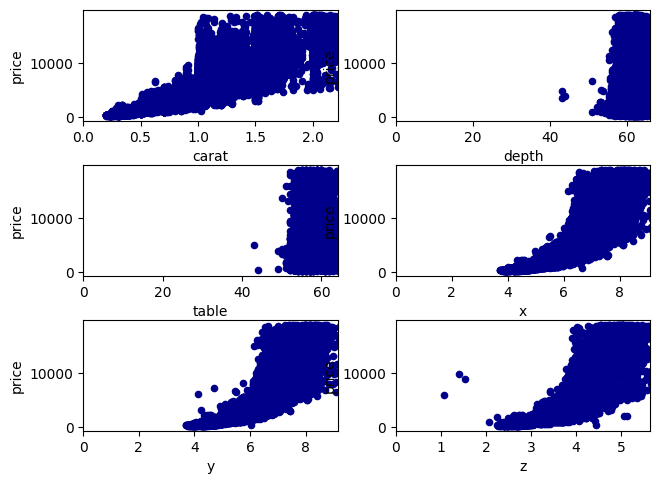

In [3]:
columns_to_plot = ['carat', 'depth', 'table', 'x', 'y', 'z']

fig, axs = plt.subplots(3,2)
fig.tight_layout()

for i in range(len(columns_to_plot)):
    column = columns_to_plot[i]
    ax = df.plot.scatter(x=column,
                      y='price',
                      c='DarkBlue',
                      ax =axs[i // 2, i % 2])

    ax.set_xlim(0, df[column].mean() + (3 * df[column].std()))

plt.show()

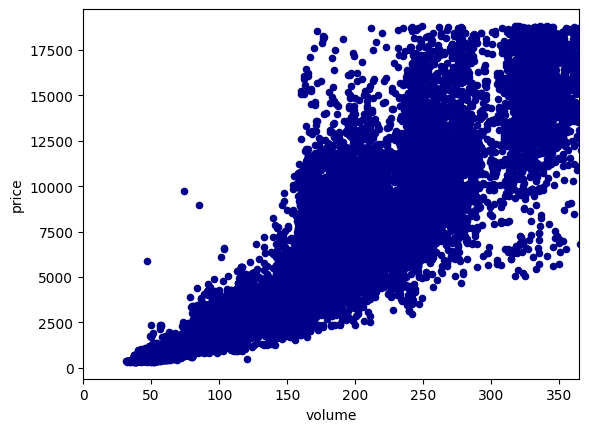

In [4]:
# x, y, and z are length, width and height in mm
# combine into volume (of bounding box)
df["volume"] = df["x"] * df["y"] * df["z"]
ax = df.plot.scatter(x='volume',
                      y='price',
                      c='DarkBlue')


ax.set_xlim(0,df["volume"].mean() + (3 * df["volume"].std()))
plt.show()

<Axes: xlabel='cut', ylabel='price'>

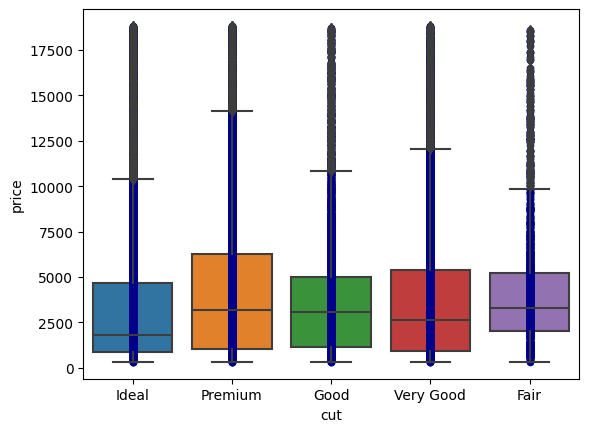

In [5]:
# plotting the 'cut' against 'price' doesn't give us much information
df.plot.scatter(x="cut", y='price', c='DarkBlue')

import seaborn as sns
sns.boxplot(x='cut', y='price', data=df)

[3456.9412010395395, 4579.684542815675, 3926.40350877193, 3981.6641006539194, 4357.50093225606]


(0.0, 4635.821709904481)

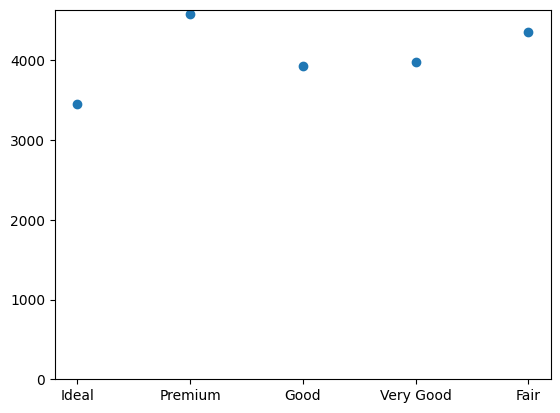

In [6]:
# maybe we can plot "cut" against average price

cuts = df["cut"].unique()
mean_prices_by_cut = [None]*len(cuts)
for i in range(len(cuts)):
    cut = cuts[i]
    mean_prices_by_cut[i] = df[df["cut"] == cut]["price"].mean()
    
print(mean_prices_by_cut)

plt.scatter(cuts, mean_prices_by_cut)
plt.ylim(0)

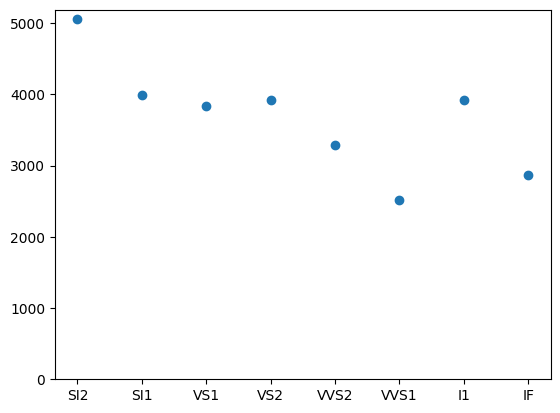

[3076.7524752475247, 5089.9739900387385, 5323.81801994302, 4480.942154736081, 3725.080205493814, 3996.8765508684864, 3168.1064363743726]


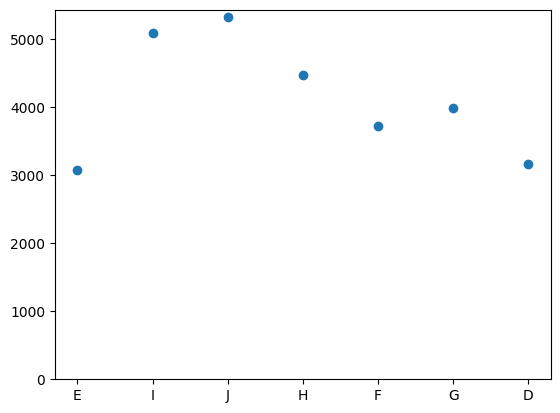

In [7]:
# same for clarity
clarities = df["clarity"].unique()
mean_prices_by_clarity = [None]*len(clarities)
for i in range(len(clarities)):
    clarity = clarities[i]
    mean_prices_by_clarity[i] = df[df["clarity"] == clarity]["price"].mean()
    

plt.scatter(clarities, mean_prices_by_clarity)
plt.ylim(0)
plt.show()

# and the same for color
colors = df["color"].unique()
mean_prices_by_color = [None]*len(colors)
for i in range(len(colors)):
    color = colors[i]
    mean_prices_by_color[i] = df[df["color"] == color]["price"].mean()
    
print(mean_prices_by_color)

plt.scatter(colors, mean_prices_by_color)
plt.ylim(0)
plt.show()

In [8]:
# one hot encoding
color_codes = df["color"].unique()
for color_code in color_codes:
    col_name = "color_is_" + color_code
    df[col_name] = (df["color"] == color_code).astype(int)
    
cuts = df["cut"].unique()
for cut in cuts:
    col_name = "cut_is_" + cut
    df[col_name] = (df["cut"] == cut).astype(int)
    
clarities = df["clarity"].unique()
for clarity in clarities:
    col_name = "clarity_is_" + clarity
    df[col_name] = (df["clarity"] == clarity).astype(int)
    
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,...,cut_is_Very Good,cut_is_Fair,clarity_is_SI2,clarity_is_SI1,clarity_is_VS1,clarity_is_VS2,clarity_is_VVS2,clarity_is_VVS1,clarity_is_I1,clarity_is_IF
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,...,0,0,1,0,0,0,0,0,0,0
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,...,0,0,0,1,0,0,0,0,0,0
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,...,0,0,0,0,1,0,0,0,0,0
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,...,0,0,0,0,0,1,0,0,0,0
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,...,0,0,1,0,0,0,0,0,0,0


# Maching Learning

In [9]:
X = df[df.columns.difference(["price", "cut", "clarity", "color", "x", "y", "z"])]
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X.describe()

,carat,clarity_is_I1,clarity_is_IF,clarity_is_SI1,clarity_is_SI2,clarity_is_VS1,clarity_is_VS2,clarity_is_VVS1,clarity_is_VVS2,color_is_D,...,color_is_I,color_is_J,cut_is_Fair,cut_is_Good,cut_is_Ideal,cut_is_Premium,cut_is_Very Good,depth,table,volume
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,...,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,0.797698,0.013687,0.033197,0.242266,0.170345,0.151521,0.227263,0.067767,0.093954,0.125631,...,0.100538,0.052077,0.029841,0.090912,0.399629,0.255564,0.224054,61.749514,57.456834,129.897567
std,0.473795,0.116189,0.179153,0.428459,0.375939,0.358559,0.419068,0.251348,0.291767,0.331436,...,0.300719,0.222185,0.170149,0.287487,0.489827,0.436182,0.416962,1.432331,2.234064,78.219789
min,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.000000,43.000000,31.707984
25%,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,61.000000,56.000000,65.189759
50%,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,61.800000,57.000000,114.840180
75%,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,62.500000,59.000000,170.846415
max,5.010000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,79.000000,95.000000,3840.598060


In [10]:
from sklearn.preprocessing import StandardScaler, RobustScaler

#scaler = StandardScaler()
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
reg = LinearRegression().fit(X_train, y_train)

train_score = reg.score(X_train, y_train)
test_score = reg.score(X_test, y_test)

print("train_score:", train_score)
print("test_score:", test_score)

train_score: 0.9153070630458103
test_score: 0.9189471992943568


In [12]:
test_index = random.randrange(X.shape[0])

print("Testing random index " + str(test_index))

x_random = scaler.transform(X)[test_index]
y_random = y[test_index]

print("y:", y_random)
print("y_predicted:", reg.predict([x_random])[0])

y_predictions = reg.predict(X_test)
mean_squared_error(y_test, y_predictions)

Testing random index 1803
y: 3053
y_predicted: 3893.0390505794567


1297541.9468956892

In [13]:
pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(reg.coef_))], axis = 1)

,0,0
0,carat,5605.244336
1,clarity_is_I1,-3737.221202
2,clarity_is_IF,1603.580019
3,clarity_is_SI1,-231.296640
4,clarity_is_SI2,-1186.953564
5,clarity_is_VS1,725.446003
6,clarity_is_VS2,409.475337
7,clarity_is_VVS1,1264.966382
8,clarity_is_VVS2,1152.003666
9,color_is_D,824.191862


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid


model = Sequential(
    [
        tf.keras.Input(shape=(X.shape[1],)),
        Dense(50, activation="relu"),
        Dense(10, activation="relu"),
        Dense(1, activation="linear")
    ], name = "my_model" 
)

model.compile(loss=tf.keras.losses.MeanSquaredError(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
model.summary()
model.fit(X_train, y_train, epochs=30)

2025-03-22 16:49:06.249329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-22 16:49:06.249501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-22 16:49:06.440847: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         1,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,771 (6.92 KB)

 Trainable params: 1,771 (6.92 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 8578767.0000
Epoch 2/30
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 970280.5625
Epoch 3/30
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 710752.8125
Epoch 4/30
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 503734.2812
Epoch 5/30
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 596709.5625
Epoch 6/30
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 494369.5312
Epoch 7/30
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 545856.6875
Epoch 8/30
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 433786.0938
Epoch 9/30
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 430619.2188
Epoch 10/30
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 444165.4688
Epoch 11/30
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 393574.9375
Epoch 12/30
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 375774.2188
Epoch 13/30
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 372295.7188
Epoch 14/30
1348/1348 ━━━━━━━━━━━

In [15]:
import math

y_predictions_nn = model.predict(X_test)


baseline_mse = mean_squared_error(y_test, np.repeat(y_test.mean(), len(y_test)))
lr_mse = mean_squared_error(y_test, y_predictions)
nn_mse = mean_squared_error(y_test, y_predictions_nn)

print(f"Baseline MSE:\t{baseline_mse:.0f} (predictions will average +- {math.sqrt(baseline_mse):.0f} from actual)")
print(f"Linear Regression MSE:\t{lr_mse:.0f} (predictions will average +- {math.sqrt(lr_mse):.0f} from actual)")
print(f"Neural Network MSE:\t{nn_mse:.0f} (predictions will average +- {math.sqrt(nn_mse):.0f} from actual)")

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Baseline MSE:	16008601 (predictions will average +- 4001 from actual)
Linear Regression MSE:	1297542 (predictions will average +- 1139 from actual)
Neural Network MSE:	345088 (predictions will average +- 587 from actual)


In [16]:
test_index = random.randrange(X.shape[0])

print("Testing random index " + str(test_index))

x_random = scaler.transform(X)[test_index]
y_random = y[test_index]

print("y:", y_random)
print("y_predicted:", model.predict( np.array(x_random).reshape(1, -1)))

y_predictions = reg.predict(X_test)
mean_squared_error(y_test, y_predictions)

Testing random index 26122
y: 15395
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
y_predicted: [[14622.873]]


1297541.9468956892